[Text(1, 0, '1'), Text(1, 1, '10'), Text(1, 2, '100')]

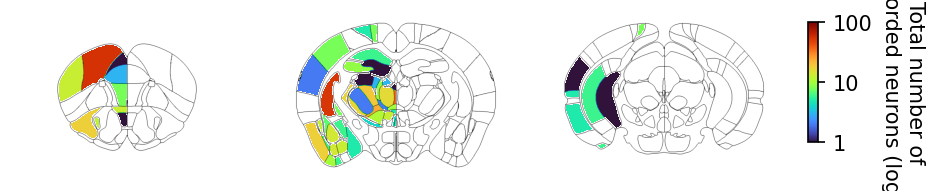

In [5]:
# From file brain_map_n_neurons.py
# #!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 14 15:19:58 2021
By: Guido Meijer
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join
from iblatlas.plots import plot_scalar_on_slice
from psychedelic_functions import paths
from iblatlas.atlas import AllenAtlas
ba = AllenAtlas(res_um=10)

# Settings
AP = [2, -1.5, -3.5]

# Paths
path_dict = paths()

# Load in results
all_neurons = pd.read_csv(join(path_dict['save_path'], 'n_neurons.csv'))
#all_neurons = pd.read_csv(join(path_dict['data_path'], 'n_neurons.csv'))
all_neurons = all_neurons[all_neurons['region'] != 'root']
all_neurons = all_neurons[all_neurons['region'] != 'void']

# %%

CMAP = 'turbo' 

# Plot brain map slices
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 4), dpi=150)

plot_scalar_on_slice(all_neurons['region'].values, np.log10(all_neurons['n_neurons'].values), ax=ax1,
                     slice='coronal', coord=AP[0]*1000, background='boundary', brain_atlas=ba,
                     mapping='Beryl', cmap=CMAP, clevels=[0, 2])
ax1.axis('off')
#ax1.set(title=f'+{np.abs(AP[0])} mm AP')

plot_scalar_on_slice(all_neurons['region'].values, np.log10(all_neurons['n_neurons'].values), ax=ax2,
                     slice='coronal', coord=AP[1]*1000, background='boundary', brain_atlas=ba,
                     mapping='Beryl', cmap=CMAP, clevels=[0, 2])
ax2.axis('off')
#ax2.set(title=f'-{np.abs(AP[1])} mm AP')

plot_scalar_on_slice(all_neurons['region'].values, np.log10(all_neurons['n_neurons'].values), ax=ax3,
                     slice='coronal', coord=AP[2]*1000, background='boundary', brain_atlas=ba,
                     mapping='Beryl', cmap=CMAP, clevels=[0, 2])
ax3.axis('off')
#ax3.set(title=f'-{np.abs(AP[2])} mm AP')

sns.despine()

f.subplots_adjust(right=0.85)
# lower left corner in [0.88, 0.3]
# axes width 0.02 and height 0.4
cb_ax = f.add_axes([0.88, 0.42, 0.01, 0.2])
cbar = f.colorbar(mappable=ax1.images[0], cax=cb_ax)
cbar.ax.set_ylabel('Total number of\nrecorded neurons (log)', rotation=270, labelpad=25)
cbar.ax.set_yticks([0, 1, 2])
cbar.ax.set_yticklabels([1, 10, 100])


In [6]:
all_neurons = pd.read_csv(join(path_dict['save_path'], 'n_neurons.csv'))
print (all_neurons)

     region  n_neurons    subject        date
0       CA1         45  ZFM-06296  2023-07-13
1      root         16  ZFM-06296  2023-07-13
2      ENTl          5  ZFM-06301  2023-07-11
3      root         19  ZFM-06301  2023-07-11
4      ACAd         10  ZFM-06296  2023-07-06
..      ...        ...        ...         ...
228      RH          5  ZFM-05486  2022-12-07
229  RSPagl          8  ZFM-05486  2022-12-07
230    VISa          5  ZFM-05486  2022-12-07
231    root          1  ZFM-05486  2022-12-07
232    void          1  ZFM-05486  2022-12-07

[233 rows x 4 columns]


In [1]:
#Modified from get_n_neurons
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 13 17:03:05 2023 by Guido Meijer
"""

import numpy as np
import pandas as pd
from os.path import join
from psychedelic_functions import remap, paths
from brainbox.io.one import SpikeSortingLoader
from one.api import ONE
from iblatlas.atlas import AllenAtlas
ba = AllenAtlas()
one = ONE()

# Get paths
path_dict = paths()

# Query pids
pids = list(one.search_insertions(project='psychedelics', query_type='remote'))

neurons_df = pd.DataFrame()
for i, pid in enumerate(pids):
    print(f'Recording {i} of {len(pids)}')
        
    # Load in neural data
    sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
    spikes, clusters, channels = sl.load_spike_sorting()
    clusters = sl.merge_clusters(spikes, clusters, channels)
            
    # No neural data
    if len(spikes) == 0:
        continue
    
    # No histology
    if 'acronym' not in clusters.keys():
        continue
    
    # Get recording info
    ses_details = one.get_details(one.pid2eid(pid)[0])
    subject = ses_details['subject']
    date = ses_details['date']
    probe = one.pid2eid(pid)[1]
    print(f'{subject} {date}')
    
    # Only keep good neurons
    clusters.acronym = clusters.acronym[clusters.label == 1]
    
    # Remap Allen acronyms to Beryl
    clusters['beryl_acronyms'] = remap(clusters['acronym'])
    
    # Get number of neurons per region
    n_neurons = np.unique(clusters['beryl_acronyms'], return_counts=True)
    
    # Add to dataframe
    this_df = pd.DataFrame(data={'region': n_neurons[0], 'n_neurons': n_neurons[1]})
    this_df['subject'] = subject
    this_df['date'] = date
    neurons_df = pd.concat((neurons_df, this_df))
    
# Save dataframe
neurons_df.to_csv(join(path_dict['save_path'], 'n_neurons.csv'), index=False)
    
    
    

Recording 0 of 53
ZFM-06296 2023-07-13
Recording 1 of 53
ZFM-06301 2023-07-11
Recording 2 of 53
ZFM-06296 2023-07-06
Recording 3 of 53
ZFM-06296 2023-07-06
Recording 4 of 53


/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06373/2023-07-05/001/alf/probe00/pykilosort/spikes.amps.npy: 100%|██████████| 24.0M/24.0M [01:07<00:00, 354kB/s] 
/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06373/2023-07-05/001/alf/probe00/pykilosort/spikes.depths.npy: 100%|██████████| 24.0M/24.0M [01:27<00:00, 276kB/s] 
/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06373/2023-07-05/001/alf/probe00/pykilosort/clusters.depths.npy: 100%|██████████| 6.24k/6.24k [00:00<00:00, 19.7kB/s]
/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06373/2023-07-05/001/alf/probe00/pykilosort/clusters.channels.npy: 100%|██████████| 12.4k/12.4k [00:00<00:00, 18.1kB/s]
/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06373/2023-07-05/001/alf/probe00/pykilosort/clusters.uuids.csv: 100%|██████████| 56.5k/56.5k [00:00<00:00, 94.4kB/s]
/home

ZFM-06373 2023-07-05
Recording 5 of 53


/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06373/2023-07-05/001/alf/probe01/pykilosort/spikes.clusters.npy: 100%|██████████| 46.7M/46.7M [00:21<00:00, 2.21MB/s]
/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06373/2023-07-05/001/alf/probe01/pykilosort/spikes.depths.npy: 100%|██████████| 93.4M/93.4M [01:15<00:00, 1.24MB/s]
/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06373/2023-07-05/001/alf/probe01/pykilosort/spikes.amps.npy: 100%|██████████| 93.4M/93.4M [01:36<00:00, 969kB/s] 
/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06373/2023-07-05/001/alf/probe01/pykilosort/spikes.times.npy:   0%|          | 0.00/93.4M [00:00<?, ?B/s]

/home/openlab/anaconda3/envs/iblenv/lib/python3.10/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)
/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/alf/probe00/pykilosort/spikes.amps.npy: 100%|██████████| 75.4M/75.4M [00:19<00:00, 3.90MB/s]
/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/alf/probe00/pykilosort/spikes.times.npy: 100%|██████████| 75.4M/75.4M [01:13<00:00, 1.03MB/s]
/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/alf/probe00/pykilosort/clusters.uuids.csv: 100%|██████████| 59.4k/59.4k [00:00<00:00, 113kB/s]
/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/alf/probe00/pykilosort/clusters.metrics.pqt: 100%|██████████| 

Downloading: /home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/alf/probe00/pykilosort/channels.localCoordinates.7776c601-8fc8-48a0-a8cf-57407cb7e30c.npy Bytes: 3200
Downloading: /home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.4e4aa236-5081-4a3c-b5cd-b92fe4426d06.npy Bytes: 3200
Downloading: /home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/alf/probe00/pykilosort/channels.mlapdv.8dd5ea23-4007-4b3b-8e7f-620e7a06b1e0.npy Bytes: 4736


  0%|          | 0/0.0030517578125 [00:00<?, ?it/s]
100%|██████████| 0.0030517578125/0.0030517578125 [00:00<00:00,  4.34s/it]

Downloading: /home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/alf/probe00/pykilosort/channels.rawInd.c9ac1d33-1566-4642-a29c-6e92f9ba1ac8.npy Bytes: 3200



100%|██████████| 0.0030517578125/0.0030517578125 [00:00<00:00,  4.57s/it]
100%|██████████| 0.0045166015625/0.0045166015625 [00:00<00:00,  2.48s/it]
100%|██████████| 0.0030517578125/0.0030517578125 [00:00<00:00,  1.33it/s]


Downloading: /home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/alf/probe00/electrodeSites.brainLocationIds_ccf_2017.c4085d03-dec4-4874-a0ad-f77764e1cdb8.npy Bytes: 3200


100%|██████████| 0.0030517578125/0.0030517578125 [00:00<00:00,  1.01it/s]


Downloading: /home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/alf/probe00/electrodeSites.mlapdv.25a9e983-0ade-49b0-ab78-69d605a0e55e.npy Bytes: 4736
Downloading: /home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/alf/probe00/electrodeSites.localCoordinates.51bbc35b-bcd9-49f3-8e03-3fcaeb716724.npy Bytes: 3200


100%|██████████| 0.0030517578125/0.0030517578125 [00:00<00:00,  2.52s/it]
100%|██████████| 0.0045166015625/0.0045166015625 [00:00<00:00,  1.58s/it]


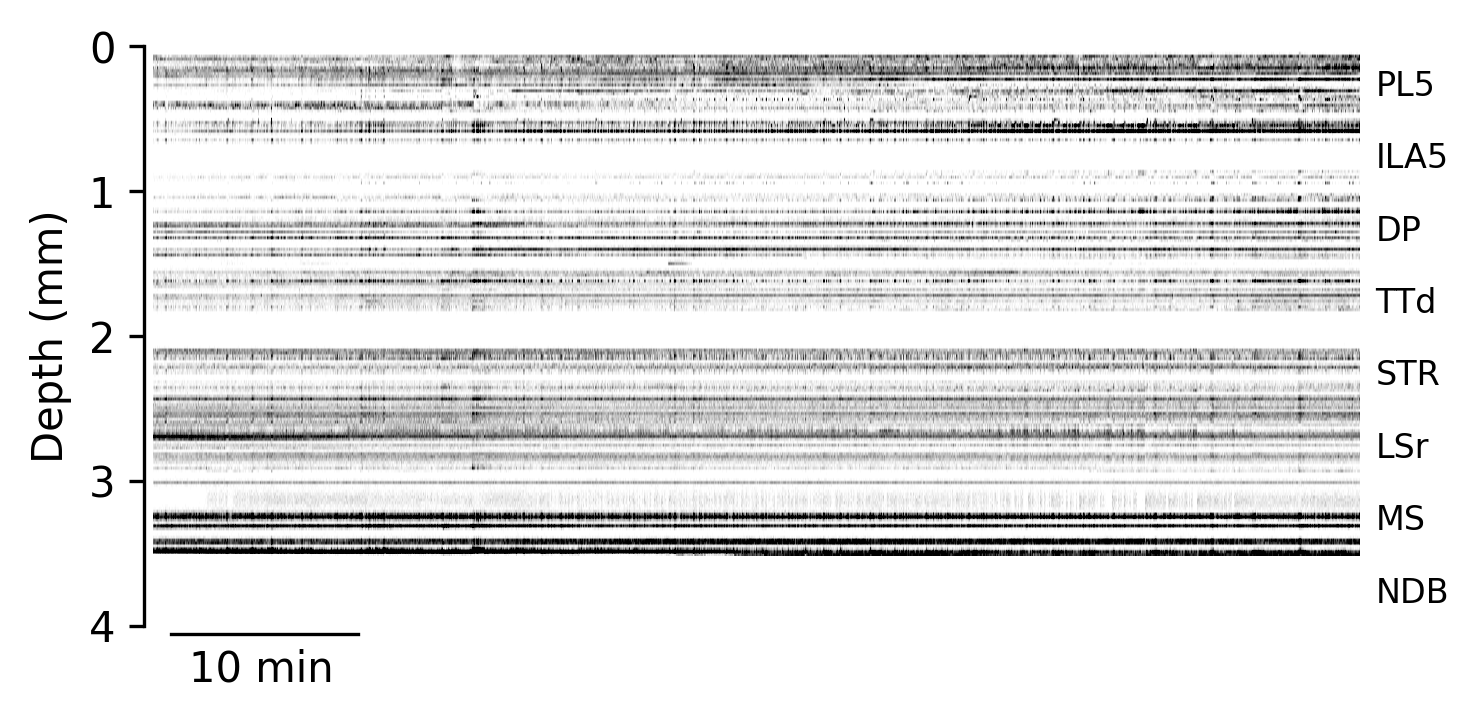

In [3]:
# Modified from plot_example_spike_raster.py
# -*- coding: utf-8 -*-
"""
Created on Mon Mar  6 11:39:45 2023 by Guido Meijer
"""

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join
from brainbox.io.one import SpikeSortingLoader
from brainbox.processing import bincount2D
from psychedelic_functions import paths, query_recordings
from one.api import ONE
from ibllib.atlas import AllenAtlas
ba = AllenAtlas()
one = ONE()

# Get paths
path_dict = paths()

PID = '540ea29f-610e-47b5-9d2b-cc2425c63ec7'
        
# Load in spikes
sl = SpikeSortingLoader(pid=PID, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

# Only keep IBL good neurons
spikes.times = spikes.times[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]
spikes.depths = spikes.depths[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]
spikes.clusters = spikes.clusters[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]

# Convert to mm
spikes.depths = spikes.depths / 1000

# Get spike raster
iok = ~np.isnan(spikes.depths)
R, times, depths = bincount2D(spikes.times[iok], spikes.depths[iok], xbin=0.01, ybin=0.02, weights=None)
    
# %% Plot figure
f, ax1 = plt.subplots(1, 1, figsize=(5, 2.5), dpi=300)
ax1.imshow(R, aspect='auto', cmap='binary', vmin=0, vmax=np.std(R),
           extent=np.r_[times[[0, -1]], depths[[0, -1]]], origin='upper')
ax1.set(ylim=[0, 4], ylabel='Depth (mm)')
#ax1.set_title('Awake', color=colors['awake'], fontweight='bold')
ax1.set(xticks=[ax1.get_xlim()[0] + 60, ax1.get_xlim()[0] + 660])
ax1.text(ax1.get_xlim()[0] + 350, 4.3, '10 min', ha='center', va='center')
ax1.axes.get_xaxis().set_visible(False)
ax1.invert_yaxis()

for i in np.arange(1, channels['acronym'].shape[0], 50):
    ax1.text(ax1.get_xlim()[-1]+50, channels['axial_um'][channels['acronym'].shape[0] - i] / 1000,
             channels['acronym'][i], fontsize=8)

plt.tight_layout()
sns.despine(trim=True, offset=2)
plt.savefig(join(path_dict['fig_path'], 'example_raster.pdf'))

In [1]:
# Modified from plot_all_spike_rasters.py
# -*- coding: utf-8 -*-
"""
Created on Mon Mar  6 11:39:45 2023 by Guido Meijer
"""

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join
from brainbox.io.one import SpikeSortingLoader
from brainbox.processing import bincount2D
from psychedelic_functions import paths, query_recordings
from one.api import ONE
from iblatlas.atlas import AllenAtlas
ba = AllenAtlas()
one = ONE()

# Get paths
path_dict = paths()

# Query recordings
rec = query_recordings(aligned=False)

# Loop over recordings
for i, pid in enumerate(rec['pid']):
        
    # Load in spikes
    sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
    spikes, clusters, channels = sl.load_spike_sorting()
    clusters = sl.merge_clusters(spikes, clusters, channels)
    if len(spikes) == 0:
        continue
    
    # Only keep IBL good neurons
    spikes.times = spikes.times[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]
    spikes.depths = spikes.depths[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]
    spikes.clusters = spikes.clusters[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]
    
    if spikes.times.shape[0] == 0:
        continue
    
    # Get spike raster
    iok = ~np.isnan(spikes.depths)
    R, times, depths = bincount2D(spikes.times[iok], spikes.depths[iok], 0.01, 20, weights=None)
        
    # Plot figure
    f, ax1 = plt.subplots(1, 1, figsize=(5, 2.5), dpi=300)
    ax1.imshow(R, aspect='auto', cmap='binary', vmin=0, vmax=np.std(R) * 2,
              extent=np.r_[times[[0, -1]], depths[[0, -1]]], origin='lower')
    plt.tight_layout()
    sns.despine(trim=True, offset=4)
    
    plt.savefig(join(path_dict['fig_path'], 'SpikeRasters', f'raster_{pid}.jpg'), dpi=600)
    plt.close(f)
    

HTTPError: [Errno 500] /insertions?django=session__project__name__icontains%2Cpsychedelics%2Csession__qc__lt%2C50: "Unsupported lookup 'project' for ForeignKey or join on the field not permitted."

In [ ]:
# Modified from lfp.ipynb in /serotonin_remapping
# https://neurostars.org/t/how-can-i-load-the-ibl-lfp-data-spikeglx-does-not-seem-to-be-available-for-python/27499/5

import spikeglx
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
''
file_path = '/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06373/2023-07-05/001/alf/probe00/pykilosort/spikes.'
sr = spikeglx.Reader(file_path)

# access metadata
meta = sr.meta
how_many_seconds = 1000
# access the first 10s of data on all non-sync channels
data = sr[0:int(how_many_seconds * sr.fs), :-sr.nsync]
all_frequencies = []
sampling_rate = int(sr.fs) # assuming sr.fs is your sampling rate
print (sampling_rate)
for i in range(data.shape[1]):
    channel_data = data[:,i]
    ft_channel_data = np.fft.rfft(channel_data)
    freqs = np.fft.rfftfreq(len(channel_data), d=1./sampling_rate)
    # all_frequencies.append((freqs, abs(ft_channel_data)))
    # power_spectrum = np.abs(ft_channel_data)**2
    power_spectrum_channel_data = np.abs(ft_channel_data)**2
    all_frequencies.append(power_spectrum_channel_data)

f0 = np.searchsorted(freqs, 4)
fn = np.searchsorted(freqs, 12)
theta_power = np.row_stack(all_frequencies)[:, f0:fn].sum(axis=1)
plt.plot(theta_power)
plt.title('Theta power for recording')
plt.show()

# Compute Fourier Transform for each channel
all_frequencies = []
sampling_rate = int(sr.fs) # assuming sr.fs is your sampling rate
print (sampling_rate)
for i in range(data.shape[1]):
    channel_data = data[:,i]
    ft_channel_data = np.fft.rfft(channel_data)
    freqs = np.fft.rfftfreq(len(channel_data), d=1./sampling_rate)
    # all_frequencies.append((freqs, abs(ft_channel_data)))
    # power_spectrum = np.abs(ft_channel_data)**2
    power_spectrum_channel_data = np.abs(ft_channel_data)**2
    all_frequencies.append(power_spectrum_channel_data)

f0 = np.searchsorted(freqs, 4)
fn = np.searchsorted(freqs, 12)
theta_power = np.row_stack(all_frequencies)[:, f0:fn].sum(axis=1)
print(theta_power.shape)
# Plot Fourier Transform for each channel
# for i, (freqs, ft) in enumerate(all_frequencies):
#     plt.figure(i)
#     plt.plot(freqs[f0:fn], ft[f0:fn])
#     plt.title(f"Channel {i} Fourier Transform")
#     plt.ylabel("Power")
#     plt.xlabel("Frequency")
    # plt.xlim(0, sampling_rate / 2)
# plt.show()


plt.plot(theta_power)